In [1]:
!git clone https://github.com/Omidzarexz/crispy-computing-machine


Cloning into 'crispy-computing-machine'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 51 (delta 22), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 16.86 MiB | 3.62 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


df_clean_train_12feature_cross_subject = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_train_12feature_cross_subject.csv")
df_clean_test_12feature_cross_subject  = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_test_12feature_cross_subject.csv")


# df_clean_train_16feature_cross_subject = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_train_16feature_cross_subject.csv")
# df_clean_test_16feature_cross_subject  = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_test_16feature_cross_subject.csv")


# df_clean_train_16feature_within_subject = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_train_16feature_within_subject_txt25.csv")
# df_clean_test_16feature_within_subject  = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_test_16feature_within_subject_txt25.csv")

df_clean_train = df_clean_train_12feature_cross_subject
df_clean_test  = df_clean_test_12feature_cross_subject

In [3]:
from scipy.signal import butter, filtfilt

def low_pass_butter(signal, cutoff=10, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)
# feature_columns = [
#     'MPU1_Acc_X', 'MPU1_Acc_Y', 'MPU1_Acc_Z',
#     'MPU1_Gyro_X', 'MPU1_Gyro_Y', 'MPU1_Gyro_Z',
#     'MPU1_Roll','MPU1_Pitch',
#     'MPU2_Acc_X', 'MPU2_Acc_Y', 'MPU2_Acc_Z',
#     'MPU2_Gyro_X', 'MPU2_Gyro_Y', 'MPU2_Gyro_Z',
#     'MPU2_Roll','MPU2_Pitch'
# ]

feature_columns = [
    'MPU1_Acc_X', 'MPU1_Acc_Y', 'MPU1_Acc_Z',
    'MPU1_Gyro_X', 'MPU1_Gyro_Y', 'MPU1_Gyro_Z',
    
    'MPU2_Acc_X', 'MPU2_Acc_Y', 'MPU2_Acc_Z',
    'MPU2_Gyro_X', 'MPU2_Gyro_Y', 'MPU2_Gyro_Z',
    
]


df_filtered_trainig = pd.DataFrame()
df_filtered_test    = pd.DataFrame()
for col in feature_columns:
    df_filtered_trainig[col] = low_pass_butter( df_clean_train[col].values
                                        , cutoff=5 # Hz
                                        , fs=100  # Hz
                                        , order=2  )
    df_filtered_test[col] = low_pass_butter( df_clean_test[col].values
                                        , cutoff=5 # Hz
                                        , fs=100  # Hz
                                        , order=2  )



# # اعمال حد مجاز [-200, 200] روی تمام ژیروسکوپ‌ها
# for col in ['MPU1_Gyro_X', 'MPU1_Gyro_Y', 'MPU1_Gyro_Z','MPU2_Gyro_X', 'MPU2_Gyro_Y', 'MPU2_Gyro_Z']:
#     df_filtered_trainig[col] = np.clip(df_filtered_trainig[col], -250, 250)
#     df_filtered_test[col]    = np.clip(df_filtered_test[col], -250, 250)


# # اعمال حد مجاز [-10, 10] روی تمام ژیروسکوپ‌ها
# for col in ['MPU1_Acc_X', 'MPU1_Acc_Y', 'MPU1_Acc_Z', 'MPU2_Acc_X', 'MPU2_Acc_Y', 'MPU2_Acc_Z']:
#     df_filtered_trainig[col] = np.clip(df_filtered_trainig[col], -10, 10)
#     df_filtered_test[col]    = np.clip(df_filtered_test[col], -10, 10)



print("\ndf_filtered_trainig shape:",df_filtered_trainig.shape)
print("\ndf_filtered_test shape:",df_filtered_test.shape)



df_filtered_trainig shape: (87394, 12)

df_filtered_test shape: (17492, 12)


In [4]:

from sklearn.preprocessing import  MinMaxScaler







scaler = MinMaxScaler(feature_range=(-1, 1))
X_data_train = scaler.fit_transform(df_filtered_trainig[feature_columns].values)  # (T, 12)


y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_data_train = y_scaler.fit_transform(df_clean_train['angle'].values.reshape(-1, 1))





X_data_test = scaler.transform(df_filtered_test[feature_columns].values)

y_data_test = y_scaler.transform(df_clean_test["angle"].values.reshape(-1,1))


# تنظیمات پنجره
window_size = 200   # 
horizon = 1        #
step_size = 5      # 

# تابع پنجره‌بندی
def create_windows_with_labels(X, y, window_size, horizon, step_size):
    X_windows = []
    y_windows = []
    for i in range(0,  len(X) - window_size - horizon + 1, step_size):
        X_windows.append(X[i:i + window_size])
        y_windows.append(y[i + window_size : i + window_size + horizon])  # برچسب آخرین نمونه در پنجره
    return np.array(X_windows), np.array(y_windows)

# ایجاد پنجره‌ها
X_windows, y_windows = create_windows_with_labels(X_data_train, y_data_train,
                                                  window_size, horizon, step_size)
if horizon==1:
    y_windows = y_windows.reshape(-1,1)




print(f"✅   (X_windows):(samples, time steps, features) → {X_windows.shape}")
print(f"✅  (y_windows): {y_windows.shape}")

step_size_for_test = 1
X_windows_test, y_windows_test = create_windows_with_labels(X_data_test, y_data_test,
                                                            window_size, horizon, step_size_for_test)

if horizon==1:
    y_windows_test = y_windows_test.reshape(-1,1)

print(f"\n✅   (X_windows_test):(samples, time steps, features) → {X_windows_test.shape}")
print(f"✅  (y_windows_test): {y_windows_test.shape}")






✅   (X_windows):(samples, time steps, features) → (17439, 200, 12)
✅  (y_windows): (17439, 1)

✅   (X_windows_test):(samples, time steps, features) → (17292, 200, 12)
✅  (y_windows_test): (17292, 1)


2025-10-17 11:06:57.270509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760699217.471073      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760699217.530331      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1760699230.529534      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


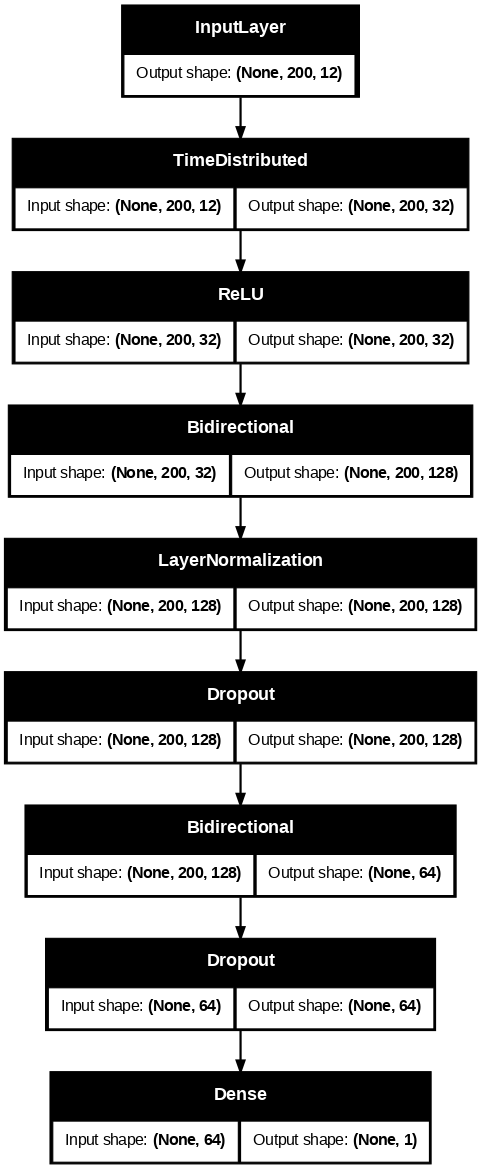

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.layers import Bidirectional

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Dense, GRU, Bidirectional, Dropout, ReLU, TimeDistributed, LayerNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

LEARNING_RATE = 0.001
lambda_loss_amount = 0.0005



def build_bi_lstm_model(input_shape, horizon=1, lambda_loss_amount=1e-4, learning_rate=1e-3):
    inputs = Input(shape=input_shape, name="input")

    # Dense projection per timestep
    x = TimeDistributed(Dense(32, kernel_regularizer=l2(lambda_loss_amount)))(inputs)
    x = ReLU()(x)

    # Stacked BiGRU layers
    x = Bidirectional(LSTM(64, return_sequences=True,
                           kernel_regularizer=l2(lambda_loss_amount)))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(LSTM(32, return_sequences=False,
                           kernel_regularizer=l2(lambda_loss_amount)))(x)
    x = Dropout(0.3)(x)

    # Output
    outputs = Dense(horizon, activation='linear')(x)

    # Model compile
    model = Model(inputs=inputs, outputs=outputs, name="BiLSTM_reg")
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

final_model = build_bi_lstm_model(input_shape=(X_windows.shape[1],X_windows.shape[2]))

# final_model.summary()

plot_model(final_model, show_shapes=True , dpi=80)

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split( X_windows, y_windows, test_size=0.2,
                                                   shuffle=False, random_state=42)


callbacks = [
    ModelCheckpoint('best_lstm_model_reg.keras', save_best_only=True, monitor='val_loss',verbose=1),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=5e-6,verbose=1)
]

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/500


I0000 00:00:1760699252.076617     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1440 - mae: 0.2388
Epoch 1: val_loss improved from inf to 0.05538, saving model to best_lstm_model_reg.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - loss: 0.1438 - mae: 0.2385 - val_loss: 0.0554 - val_mae: 0.1147 - learning_rate: 0.0010
Epoch 2/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0516 - mae: 0.1104
Epoch 2: val_loss improved from 0.05538 to 0.04175, saving model to best_lstm_model_reg.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0516 - mae: 0.1103 - val_loss: 0.0418 - val_mae: 0.0992 - learning_rate: 0.0010
Epoch 3/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0379 - mae: 0.0855
Epoch 3: val_loss improved from 0.04175 to 0.03537, saving model to best_lstm_model_reg.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0379 - mae: 0.0855 - val_loss: 0.0354 - val_mae: 0.0939 - learning_rate: 0.0010
Epoch 4/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0316 - mae: 0.0770
Epo

In [7]:
    from tensorflow.keras.models import load_model
    from sklearn.metrics import  mean_absolute_error
    
    
    # model = load_model('best_lstm_model_reg.keras')
    # پیش‌بینی روی داده تست
    y_pred_scaled = final_model.predict(X_windows_test)  # (N, 1)
    
    # برگرداندن به مقیاس اصلی
    y_pred_original = y_scaler.inverse_transform(y_pred_scaled)
    y_true_original = y_scaler.inverse_transform(y_windows_test)  
    
    
    
    
    mae = mean_absolute_error(y_true_original, y_pred_original)
    mae2 = mean_absolute_error(y_windows_test, y_pred_scaled)
    
    print(f"Test MAE(scaled): {mae2:.3f}")
    print(f"Test MAE(true value): {mae:.3f}")


541/541 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step
Test MAE(scaled): 0.083
Test MAE(true value): 1.718


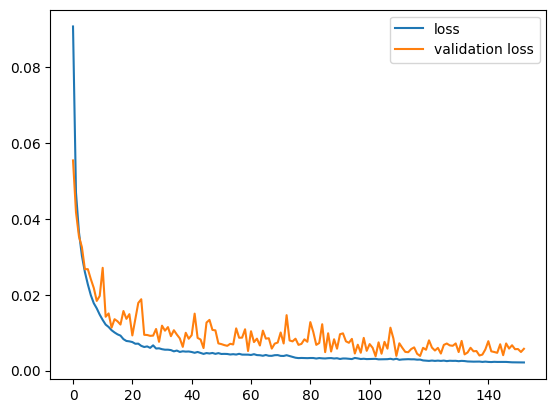

In [8]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

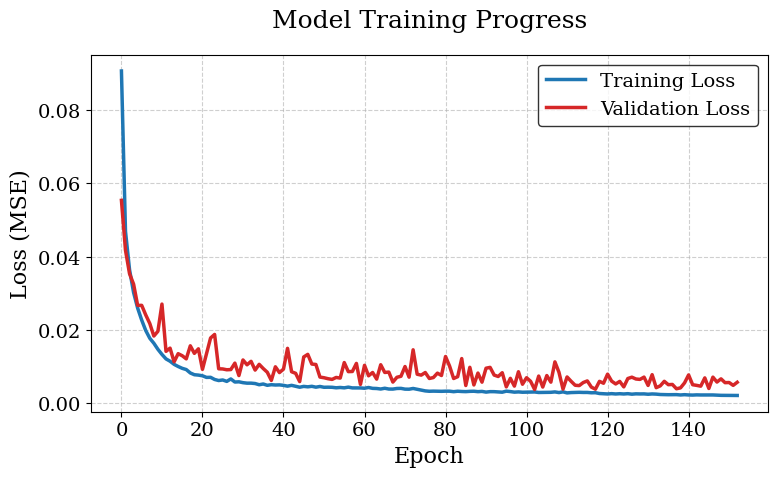

In [9]:
import matplotlib.pyplot as plt

# Set font sizes and styles for publication
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'serif',  # Optional: use serif font (common in papers)
    'figure.figsize': (8, 5)
})

# Plot training & validation loss
plt.plot(history.history["loss"], label="Training Loss", linewidth=2.5, color='tab:blue')
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2.5, color='tab:red')

# Add title and axis labels
plt.title("Model Training Progress", fontsize=18, pad=20)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

# Improve layout and add grid
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(frameon=True, loc='upper right', shadow=False, edgecolor='black')

# Use tight layout to prevent clipping
plt.tight_layout()

# Save high-resolution figure for your article
plt.savefig("training_validation_loss.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig("training_validation_loss.png", format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [10]:
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

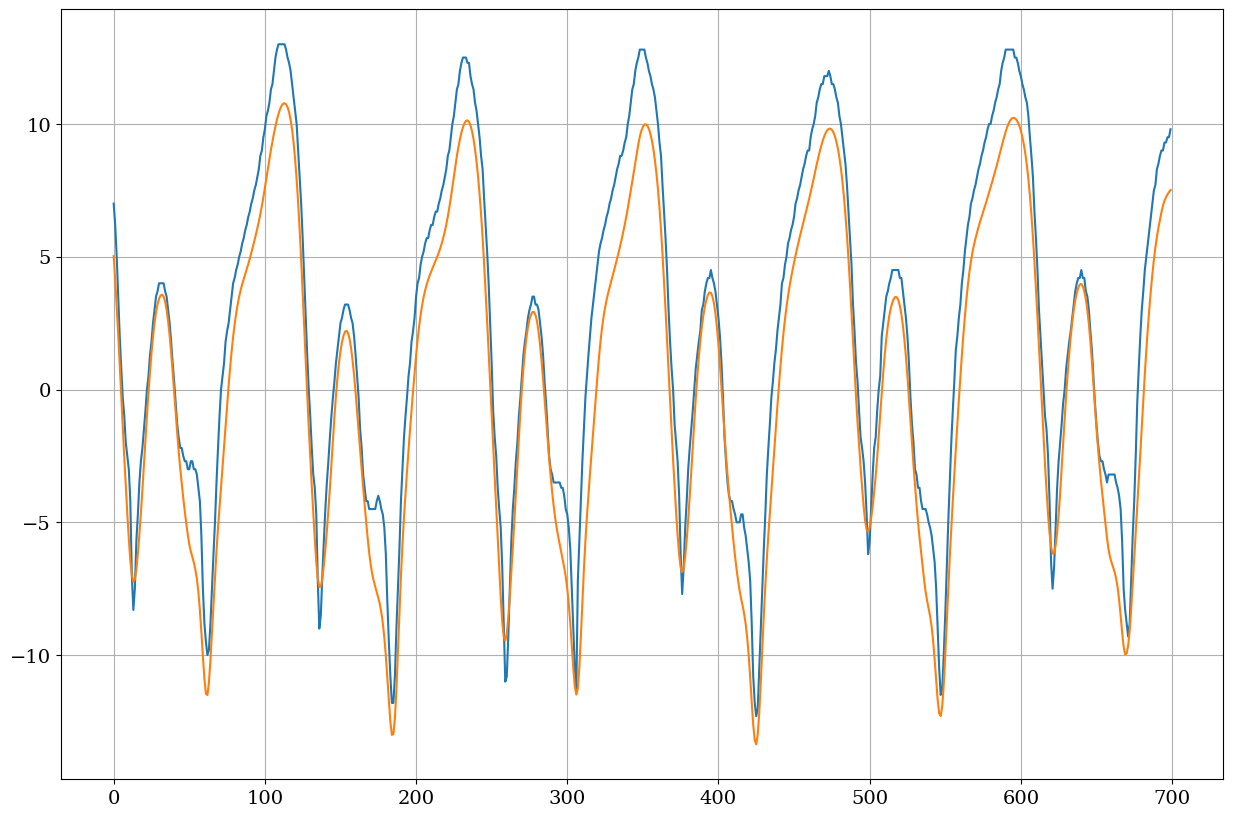

In [11]:
y_true_original = tf.squeeze(y_true_original)
y_pred_original = tf.squeeze(y_pred_original)
n1=9200
n2=9900
plt.figure(figsize=(15,10))
plt.plot(y_true_original[n1:n2])
plt.plot(y_pred_original[n1:n2])
plt.grid()

